In [1]:
# !pip install matplotlib 

# NUMPY SHAPE SUCKS 

In [2]:
import json


from typing import List, Tuple
from typing_extensions import Self 

from PIL import Image
from IPython.display import HTML
from io import BytesIO
from base64 import b64encode



# REF OBJ 

In [3]:

import shapez2_render as Render 
import shapez2_gameinfo as GlobalInfos 
import shapez2_operation as ref
import shapez2_render as Render 

from utils.mdatabase import *



ModuleNotFoundError: No module named 'mdatabase'

In [4]:
class RefShape:
    def __init__(self, shapeCode:str) -> None:
        self.shape = ref.Shape.fromShapeCode(shapeCode)
  
    def toCode(self) -> str:
        return self.shape.toShapeCode()
    
    def show(self, comment=None) -> str:
        pil_im = Render.renderShape(self.toCode(), 100)._image
        b = BytesIO()  
        pil_im.save(b, format='png')
        if comment:
            print (comment)
        display(HTML("<img style='padding:0;margin:0' src='data:image/png;base64,{0}'/>".format(b64encode(b.getvalue()).decode('utf-8'))))


    def __repr__(self) -> str:
        return self.toCode()
        layers = self.shape.toListOfLayers()
        layers = [    [s[i:i+2] for i in range(0, len(s), 2)] for s in layers]
        h1, h2 = "", ""
        s1 = ""
        s2 = ""
        for l in range(0, len(layers)):
            h1 += "_____    "
            s1 += layers[l][3] + " " + layers[l][0] + "    "
            s2 += layers[l][2] + " " + layers[l][1] + "    "
            h2 += "⎺⎺⎺⎺⎺    "
        return ('\n'.join([h1, s1, s2, h2]))
        # for layer
        # print(layers)
        # layers.reverse()
        # print ("________\n" + '\n'.join(layers) + "\n⎺⎺⎺⎺⎺⎺⎺⎺")


def refShow(sl: List[RefShape]) -> None:
    
    def toPilImgData (s:RefShape):
        pil_im = Render.renderShape(s.toCode(), 100)._image
        b = BytesIO()  
        pil_im.save(b, format='png')
        return b64encode(b.getvalue()).decode('utf-8')

    imgsData = [toPilImgData(s) if s else None for s in sl]

    htmlImgs =  ["<img style='padding:0;margin:0' width='40px' height='40px' src='data:image/png;base64,{0}'/>".format(data) if data else '' for data in imgsData]
    htmlImgs = ''.join(htmlImgs)
    display(HTML(htmlImgs))

     

def refrot90(s:RefShape) -> RefShape:
    shape2 = ref.rotate90CW(s.shape)[0]
    return RefShape(shape2.toShapeCode())

def refrot270(s:RefShape) -> RefShape:
    shape2 = ref.rotate90CCW(s.shape)[0]
    return RefShape(shape2.toShapeCode())

def refrot180(s:RefShape) -> RefShape:
    shape2 = ref.rotate180(s.shape)[0]
    return RefShape(shape2.toShapeCode())

def refpushpin(s:RefShape) -> RefShape:
    shape2 = ref.pushPin(s.shape)[0]
    return RefShape(shape2.toShapeCode())

def refgenCrystal(s:RefShape, color:str) -> RefShape:
    shape2 = ref.genCrystal(s.shape, color)[0]
    return RefShape(shape2.toShapeCode())


def refcut(s:RefShape) -> list[RefShape]:
    shape = ref.coreCut(s.shape)
    return RefShape(shape[0].toShapeCode()), RefShape(shape[1].toShapeCode())

def refswap(s:RefShape, shapeB:RefShape) -> list[RefShape]:
    shape = ref.swapHalves(s.shape, shapeB.shape)
    return RefShape(shape[0].toShapeCode()), RefShape(shape[1].toShapeCode())

def refstack(s:RefShape, topShape:RefShape) -> RefShape:
    shape = ref.coreStack(s.shape, topShape.shape)
    return RefShape(shape[0].toShapeCode())

def refpaint(s:RefShape, color:str) -> RefShape:
    shape = ref.topPaint(s.shape, color)
    return RefShape(shape[0].toShapeCode())

def refpaint(s:RefShape, color:str) -> RefShape:
    shape = ref.topPaint(s.shape, color)
    return RefShape(shape[0].toShapeCode())

def reflayers(s:RefShape) -> Tuple[RefShape, RefShape, RefShape, RefShape]:
    sCode = s.toCode()
    sCodePart = sCode.split(':')
    return [RefShape(sCodePart[i]) if i < len(sCodePart) else None for i in range(0, 4)]
    
def refanalye(s:RefShape) -> Tuple[RefShape, str]:
    sCode = s.toCode()
    sCodeFirstPart = sCode.split(':')[0]
    color = '-' if  sCodeFirstPart[0] in ('P', '-') else sCodeFirstPart[1]
    colorShape = '-' if  sCodeFirstPart[0] in ('P', '-') else 'u'
    codeAnalyse = sCodeFirstPart[0] + colorShape + "------"
    return RefShape(codeAnalyse), color


def refquadrot(s:RefShape) -> Tuple[RefShape, RefShape, RefShape, RefShape]:
    CB = refrot90(s)
    CC = refrot90(CB)
    CD = refrot90(CC)
    return s, CB , CC, CD



# INDEX 

In [5]:

class InfoQuad:
    
    left:Self
    right:Self

    def __init__(self, quad:RefShape, idxL, idxQ):
        self.quad = quad
        self.idxL = idxL
        self.idxQ = idxQ
        self.baseInfo()

    def baseInfo(self) -> None:
        filterShape , selectedColor = refanalye(self.quad)
        self.shapeCode = filterShape.toCode()
        self.shapeCode = self.shapeCode if self.shapeCode != 'cu------' else 'P-------'

        self.color = selectedColor if selectedColor and selectedColor not in ['-', 'u'] else None
        self.isPin = filterShape.toCode() == "P-------"
        self.isCrystal =  filterShape.toCode() == "cu------"
        self.isVoid = filterShape.toCode() == "--------"
        self.isShape = not self.isPin and not self.isCrystal and not self.isVoid

    def link(self, tableInfo:List[List[Self]]) -> None:
        self.left = tableInfo[self.idxL][(self.idxQ + 1) % 4]
        self.right = tableInfo[self.idxL][(self.idxQ - 1) % 4]
        self.top = tableInfo[self.idxL + 1][self.idxQ] if self.idxL + 1 < len(tableInfo) else None
        self.bottom = tableInfo[self.idxL - 1][self.idxQ] if self.idxL - 1 >= 0 else None

    def canLayer(self):
        if self.isCrystal:
            if self.left.isVoid or self.left.isPin:
                return False
            if self.right.isVoid or self.right.isPin:
                return False
        return True            


class InfoLayer:
    infos:List[InfoQuad]

    def __init__(self, infos:List[InfoQuad]):
        self.infos = infos


    def haveCrytal(self):
        return any([i.isCrystal for i in self.infos])

    def crystalColor(self):
        for quad in self.infos:
            if quad.isCrystal:
                return quad.color

    def canLayer(self):
        if self.haveCrytal():
            if any([i.isVoid for i in self.infos]) or any([i.isPin for i in self.infos]):
                return  False
        return True
    

class InfoQuadRow:
    infos:List[InfoQuad]

    def __init__(self, infos:List[InfoQuad]):
        self.infos = infos

    def haveCrytal(self):
        return any([i.isCrystal for i in self.infos])


class InfoShape:
    tableInfo:List[List[InfoQuad]]
    layerInfo:List[InfoLayer]
    rowInfo:List[InfoQuadRow]

    def __init__(self, shape:RefShape):
        # Create base info for each quad
        self.tableInfo = [ 
            [
                InfoQuad(quad , idxL, idxQ) 
                for idxQ, quad in enumerate(refquadrot(layer))  
            ]
            for idxL, layer in enumerate([it for it in reflayers(shape) if it]) 
        ]
        # 
        self.lSize = len(self.tableInfo)
        self.qSize = len(self.tableInfo[0])

        # Link shape together
        for layerInfo in self.tableInfo: 
            for quadInfo in layerInfo: 
                quadInfo.link(self.tableInfo)

        # Create layer , and row object
        self.layerInfo = [InfoLayer(layer) for layer in self._getLayers()]
        self.rowInfo = [InfoQuadRow(row) for row in self._getQuadRow()]


    def _getLayers(self) -> List[InfoQuad]:
        return self.tableInfo

    def _getQuadRow(self) -> List[InfoQuad]:
        return [[self.tableInfo[l][q] for l in range(0, self.lSize)] for q in range(0, self.qSize)]
    
    def canLayer(self):
        return  all([lInfo.canLayer() for lInfo in self.layerInfo])

InfoShape(RefShape('----crCu'))


In [10]:
def transform_simInfo(shape:RefShape):
    code = shape.toCode()
    codeTab = code.split(':')
    outCode = []
    outCode.append([c[0:2] + 'Cu' + c[0:2] + 'Cu' for c in codeTab])
    outCode.append([c[2:4] + 'Cu' + c[2:4] + 'Cu' for c in codeTab])
    outCode.append([c[4:6] + 'Cu' + c[4:6] + 'Cu' for c in codeTab])
    outCode.append([c[6:8] + 'Cu' + c[6:8] + 'Cu' for c in codeTab])

    outCode = [':'.join(it) for it in outCode]
    outShape = [RefShape(it) for it in outCode]
    return outShape


transform_simInfo(RefShape('----crCu'))

[--Cu--Cu, --Cu--Cu, crCucrCu, CuCuCuCu]

In [11]:
def createQuadShape(qinfo:InfoQuad):
    if qinfo.isVoid:
        return None
    if qinfo.isPin:
        return RefShape('P-------')

    shape = RefShape(qinfo.shapeCode)
    if qinfo.color:
        shape = refpaint(shape, qinfo.color)
    return shape  


def createLayerShape(layerInfo:List[InfoQuad]):
    layerShape = None
    for idx, qInfo in enumerate(layerInfo):
        shape = createQuadShape(qInfo)
        if shape is None :
            continue
        for i in range(0, idx):
            shape = refrot270(shape)
        if layerShape is None: 
            layerShape = shape
        else:
            layerShape = refstack(layerShape, shape)


    return layerShape

In [12]:
       
def stackLayer(shapeInfo:InfoShape) -> RefShape: 
    
    shape = None
    for lInfo in shapeInfo.layerInfo:
        layerShape = createLayerShape(lInfo.infos)
        if shape is None: 
            shape = layerShape
        else:
            shape = refstack(shape, layerShape)

        if lInfo.haveCrytal():
            shape = refgenCrystal(shape, lInfo.crystalColor())

    return shape
    

def quadSwap(shapeInfo:InfoShape) -> RefShape:

    shape = None

    



In [13]:
SHAPE_TO_BUILD = "RrRgRbRy:CrCgCbCy:WrWgWbWy:SrSgSbSy"


def generateShape(shapeCode):
    shape = RefShape(shapeCode)
   
    shapeInfo = InfoShape(shape)
    
    if shapeInfo.canLayer():
        return stackLayer(shapeInfo)
    return None

# print (json.dumps(quadLayersInfo[0][0], indent=4))
generateShape(SHAPE_TO_BUILD)


RrRgRbRy:CrCgCbCy:WrWgWbWy:SrSgSbSy

In [14]:
testedShapes = MDataBase("key_1_on_1").get_n_layer_shapes(1)
print (len(testedShapes))


for it in testedShapes[0:]:
    it = it.replace('cu', 'cr')
    # print ('{' + it + '}')
    genShape = generateShape(it)

    if genShape is None:
        pass
        # print ("None:", it)
    elif ( genShape.toCode() != it): 
        pass
        print ("Error:", it, genShape.toCode())
    else :
        pass
        # print ("OK:", it, genShape.toCode())




NameError: name 'MDataBase' is not defined

In [167]:


TMAM_SHAPE = [
    'cr----cr:cb----cb:RgRgRgRg:cw----cw:cccccccc',
    'P---P---:P-------:crCu--Cu',
    'P---P---:Ru------:crCu--Cu',
    'Cu------:CuCu----:CucrCuCu',
    'P---P---:P-------:crCu--Cu:P-------:CucrCu--',
    "Cu------:CuCu--Cu",
    "crcr----:RgRgRgRg:cbcb----:cwcwcwcw"
    "Cu------:CuCu----:CucrCuCu", 
]



a = 1 


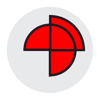


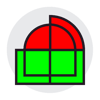


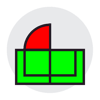


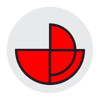

In [130]:

a = RefShape('Cr------:CrCr--Cr')
QA = RefShape('CrRgCrRg:CrRgCrRg')
QB = RefShape('--Rg--Rg:CrRgCrRg')
QC = RefShape('--Rg--Rg:--Rg--Rg')
QD = RefShape('--Rg--P-:CrRgCrRg')

a.show()

QAB, _ = refswap(QA, refrot90(QB))
QDC, _ = refswap(QC, refrot90(QD))

QAB.show()
QDC.show()

final, _ = refswap(refrot90(QAB), refrot270(QDC))
final.show()